In [1]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from svetlanna.units import ureg

import analytical_solutions as anso

# Прямая задача дифракции на квадратной апертуре

В этом примере численно решена прямая задача дифракции плоской волны на квадратной апертуре из модуля `svetlanna.elements`

## Создание расчетной сетки с использованием класса`SimulationParameters`

In [3]:
# размер экрана
lx = 4 * ureg.mm
ly = 4 * ureg.mm

# расстояние между экраном и квадратной апертурой, мм
z = 220 * ureg.mm

# размер квадратной апертуры, мм
a = 1 * ureg.mm

# длина волны
wavelength = 1064 * ureg.nm

# количество точек в расчетной сетке
Nx = 2048
Ny = 2048

sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [4]:
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Создание плоской волны с использованием `svetlanna.wavefront.plane_wave`

Создадим плоскую волну, которая падает на квадратную апертуру:

In [5]:
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=sim_params,
    distance=0 * ureg.cm,
    wave_direction=[0, 0, 1]
)

## Создание квадратной апертуры с использованием`svetlanna.elements.RectangularAperture`

In [6]:
square_aperture = elements.RectangularAperture(
    simulation_parameters=sim_params,
    height=a,
    width=a,
)

Визуализируем форму квадратной апертуры с использованием метода класса `.get_transmission_function()`

In [7]:
aperture_transmission_function = square_aperture.get_transmission_function()

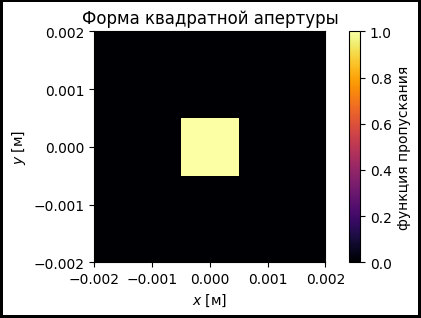

In [8]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, aperture_transmission_function, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Форма квадратной апертуры')
ax.set_xlabel('$x$ [м]')
ax.set_ylabel('$y$ [м]')
fig.colorbar(im1, label='функция пропускания')

## Распределение интенсивности на экране после прохождения квадратной апертуры

В этой секции будет численно решена прямая задача дифракции плоской волны на квадратной апертуре с использованием метода углового спектра из класса `FreeSpace`

In [9]:
field_after_aperture = square_aperture.forward(
    incident_wavefront=incident_field
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z,
    method="AS"
)

output_wavefront = free_space.forward(
    incident_wavefront=field_after_aperture
)

output_intensity = output_wavefront.intensity

Визуализируем распределение интенсивности:

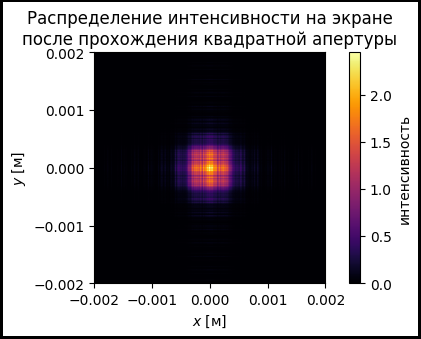

In [10]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, output_intensity, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Распределение интенсивности на экране\nпосле прохождения квадратной апертуры')
ax.set_xlabel('$x$ [м]')
ax.set_ylabel('$y$ [м]')
fig.colorbar(im1, label='интенсивность')

## Сравнение с аналитическим решением

В этой секции сравним распределение интенсивности, полученное численно с помощью метода углового спектра, с аналитически известным решением, которое выражается через интегралы Френеля

In [11]:
rect_int = anso.SquareFresnel(
    distance=z,
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    square_size=a,
    wavelength=wavelength
)

intensity_analytic = rect_int.intensity()

Визуализируем распределения интенсивности:

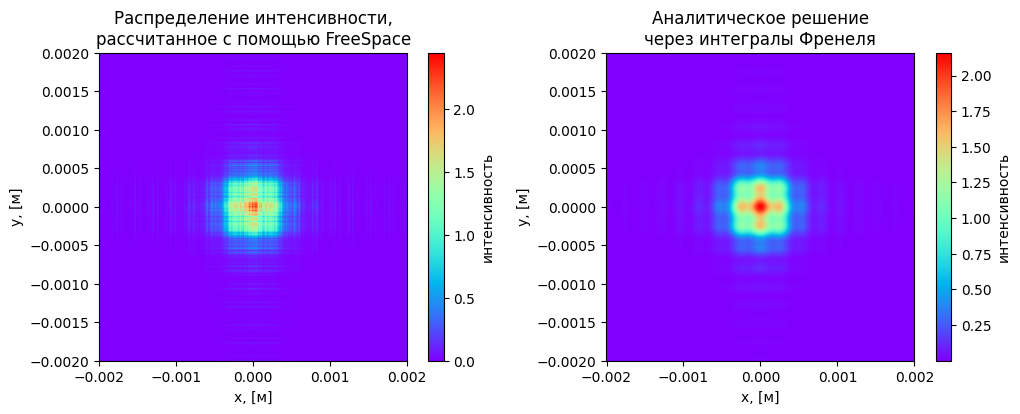

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
beam1 = ax[0].pcolormesh(x_grid, y_grid, output_intensity, cmap='rainbow')
beam2 = ax[1].pcolormesh(x_grid, y_grid, intensity_analytic, cmap='rainbow')

ax[0].set_title('Распределение интенсивности,\nрассчитанное с помощью FreeSpace')
ax[1].set_title('Аналитическое решение\nчерез интегралы Френеля')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_xlabel('x, [м]')
ax[0].set_ylabel('y, [м]')
ax[1].set_xlabel('x, [м]')
ax[1].set_ylabel('y, [м]')
fig.colorbar(beam1, ax=ax[0], label='интенсивность')
fig.colorbar(beam2, ax=ax[1], label='интенсивность')